# 练习8：异常检测和推荐系统

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt 

## 异常检测

### 查看数据

In [3]:
data = sio.loadmat('./data/ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

Text(0, 0.5, 'Throughput [mb/s]')

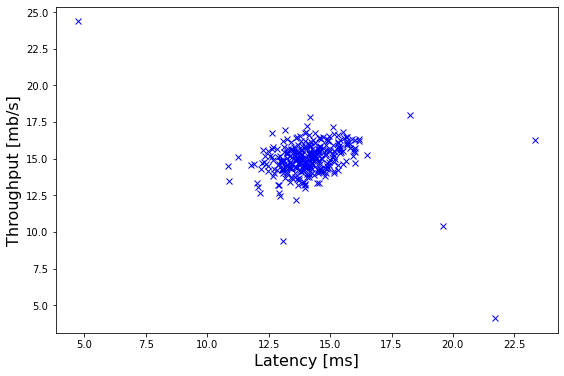

In [4]:
plt.figure(figsize=(9,6))
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency [ms]',fontsize=16)
plt.ylabel('Throughput [mb/s]',fontsize=16)

### 高斯分布模型

In [5]:
# 参数估计
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.var(X, axis=0)
    return mu,sigma

In [9]:
mu,sigma = estimate_gaussian(X)
mu,sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

TypeError: Length of x (6) must match number of columns in z (2)

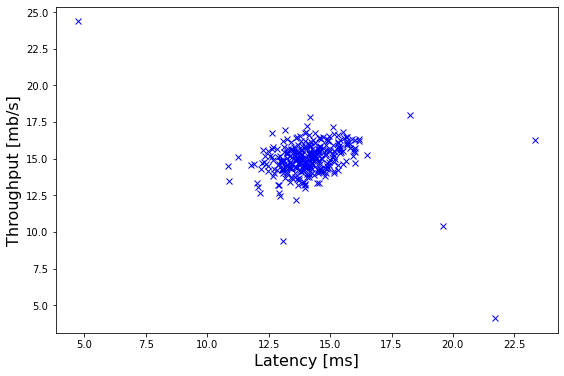

In [14]:
from scipy import stats
dist = stats.norm(mu, sigma)
z_plt = dist.pdf(X)

X_plt = np.arange(0,30,5)
y_plt = np.arange(0,30,5)

plt.figure(figsize=(9,6))
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency [ms]',fontsize=16)
plt.ylabel('Throughput [mb/s]',fontsize=16)
mycontour = plt.contour( X_plt, y_plt, z_plt, [0])

### 可视化

## 推荐系统